## Part 2D - CUPED with heavy tails and outliers (ARPU)
This notebook focuses on a very common real-world issue: ARPU / revenue is heavy-tailed.

When revenue has outliers, simple t-tests on raw ARPU may behave poorly:

- variance becomes huge,
- confidence intervals are wide,
- empirical power is low at realistic sample sizes.
  
We compare several practical approaches and show how they interact with CUPED:

- **Raw ARPU**
- **Winsorized ARPU** (cap extreme values)
- **Log-ARPU** (log1p(revenue) then interpret in log-units)
- **Trimmed mean ARPU** (remove a small fraction of extremes)

For each approach, we compare:

- base (no CUPED)
- CUPED using pre-period revenue as a covariate
  
Outputs:

- estimated CUPED theta and variance reduction
- CI widths and p-values
- empirical power / type I error in a small simulation loop

In [2]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

ALPHA = 0.05
RNG = np.random.default_rng(123)

repo_root = Path("..").resolve()
src_path = (repo_root / "src").resolve()
if (src_path / "tecore").exists() and str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

from tecore.simulate import SyntheticB2CConfig, generate_user_level_data
from tecore.variance_reduction import cuped_split_adjust

## 1) Generate a heavy-tailed dataset
We intentionally increase tail heaviness by:

- increasing revps_lognorm_sigma
- increasing high_spender_share
- increasing high_revps_multiplier
  
We keep the dataset user-level and aggregated over the post period.

In [3]:
cfg = SyntheticB2CConfig(
    n_users=80_000,
    seed=42,
    effect_type="mixed",
    lift_sessions=0.03,
    lift_rev_per_session=0.03,
    include_binary=False,

    # Make tails heavier:
    revps_lognorm_sigma=1.35,
    high_spender_share=0.05,
    high_revps_multiplier=10.0,

    # Keep decent pre/post correlation for CUPED to work:
    monetization_latent_sigma=0.8,
)

df = generate_user_level_data(cfg)
df.shape, df.head()

((80000, 6),
    user_id    group  sessions_pre  revenue_pre  sessions   revenue
 0        1  control             7     9.661638         0  0.000000
 1        2     test             5     1.750506         4  1.539529
 2        3  control             2     0.438025         3  0.621919
 3        4  control             5     0.563713         3  0.270170
 4        5     test             1     0.200404         2  0.332958)

## 2) Quick distribution check
We look at:

- histogram of revenue (clipped for visibility)
- log-histogram
- a simple boxplot (showing how extreme the tail is)

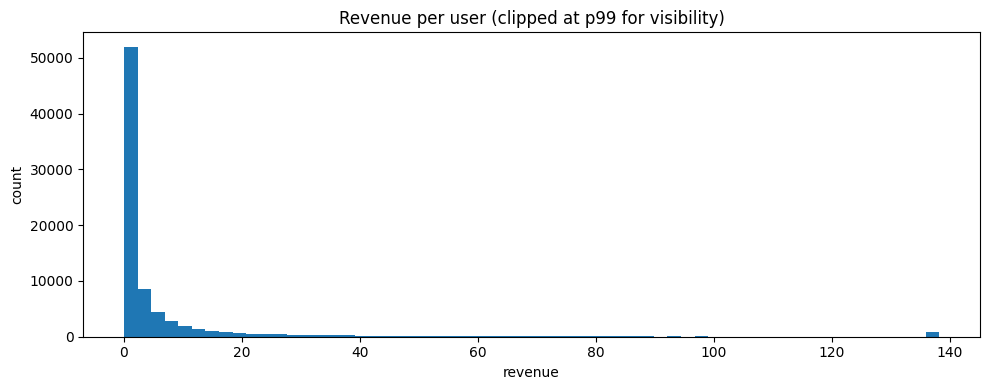

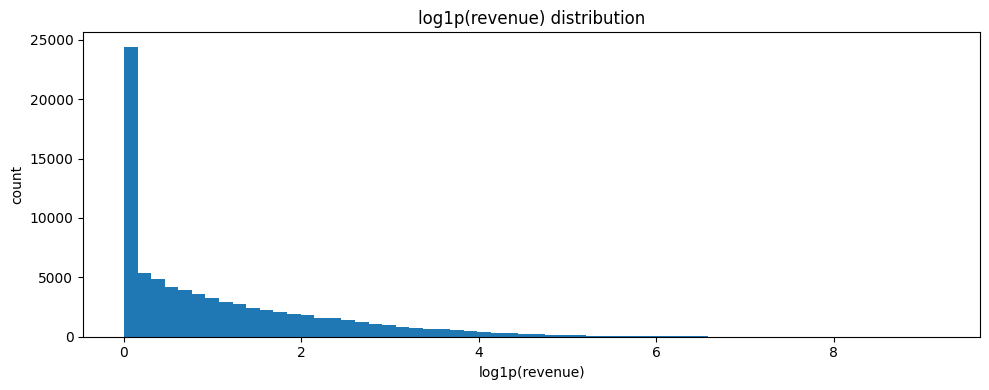

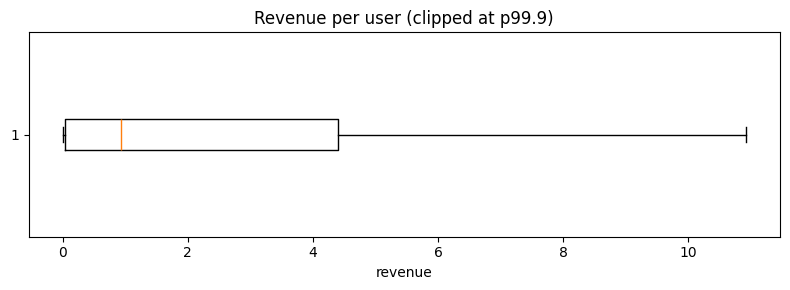

(138.15818061123898, 731.2435230012275)

In [4]:
rev = df["revenue"].to_numpy(dtype=float)

p99 = np.quantile(rev, 0.99)
p999 = np.quantile(rev, 0.999)

fig = plt.figure(figsize=(10, 4))
plt.hist(np.clip(rev, 0, p99), bins=60)
plt.title("Revenue per user (clipped at p99 for visibility)")
plt.xlabel("revenue")
plt.ylabel("count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.hist(np.log1p(rev), bins=60)
plt.title("log1p(revenue) distribution")
plt.xlabel("log1p(revenue)")
plt.ylabel("count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 3))
plt.boxplot(np.clip(rev, 0, p999), vert=False, showfliers=False)
plt.title("Revenue per user (clipped at p99.9)")
plt.xlabel("revenue")
plt.tight_layout()
plt.show()

p99, p999

## 3) Utility functions
We implement:

- Welch t-test effect + CI
- winsorization and trimming helpers
- a unified runner: base vs CUPED for a chosen transformation

In [5]:
def split_groups(df: pd.DataFrame):
    c = df[df["group"] == "control"].copy()
    t = df[df["group"] == "test"].copy()
    return c, t


def welch_ttest_effect(y_c: np.ndarray, y_t: np.ndarray, alpha: float = ALPHA):
    stat, pval = stats.ttest_ind(y_t, y_c, equal_var=False)

    eff = float(np.mean(y_t) - np.mean(y_c))
    se = float(np.sqrt(np.var(y_t, ddof=1)/len(y_t) + np.var(y_c, ddof=1)/len(y_c)))
    z = stats.norm.ppf(1 - alpha/2)
    ci = (eff - z*se, eff + z*se)

    return {"effect": eff, "ci_low": ci[0], "ci_high": ci[1], "p_value": float(pval), "se": se}


def winsorize(x: np.ndarray, lower_q: float = 0.0, upper_q: float = 0.99) -> np.ndarray:
    x = np.asarray(x, dtype=float)
    lo = np.quantile(x, lower_q)
    hi = np.quantile(x, upper_q)
    return np.clip(x, lo, hi)


def trim_mask(x: np.ndarray, lower_q: float = 0.0, upper_q: float = 0.99) -> np.ndarray:
    x = np.asarray(x, dtype=float)
    lo = np.quantile(x, lower_q)
    hi = np.quantile(x, upper_q)
    return (x >= lo) & (x <= hi)


def run_base_vs_cuped(
    y_c: np.ndarray,
    y_t: np.ndarray,
    x_c: np.ndarray,
    x_t: np.ndarray,
    alpha: float = ALPHA,
):
    base = welch_ttest_effect(y_c, y_t, alpha=alpha)
    cup_c, cup_t = cuped_split_adjust(y_c, x_c, y_t, x_t)
    adj = welch_ttest_effect(cup_c.y_adj, cup_t.y_adj, alpha=alpha)

    return {
        "base": base,
        "cuped": {**adj, "theta": cup_c.theta, "var_reduction_control": cup_c.var_reduction},
    }

## 4) Compare approaches for ARPU
Covariate for CUPED:

pre-period revenue (revenue_pre)
Approaches:

- raw revenue (ARPU)
- winsorized revenue (cap at p99)
- log1p(revenue)
- trimmed mean (drop top 1%)

In [6]:
c, t = split_groups(df)

y_c_raw = c["revenue"].to_numpy(dtype=float)
y_t_raw = t["revenue"].to_numpy(dtype=float)
x_c_raw = c["revenue_pre"].to_numpy(dtype=float)
x_t_raw = t["revenue_pre"].to_numpy(dtype=float)

# 1) Raw
res_raw = run_base_vs_cuped(y_c_raw, y_t_raw, x_c_raw, x_t_raw)

# 2) Winsorized at p99 (apply caps independently per full sample for simplicity)
y_all_win = winsorize(df["revenue"].to_numpy(dtype=float), upper_q=0.99)
x_all_win = winsorize(df["revenue_pre"].to_numpy(dtype=float), upper_q=0.99)

y_c_win = y_all_win[df["group"].to_numpy() == "control"]
y_t_win = y_all_win[df["group"].to_numpy() == "test"]
x_c_win = x_all_win[df["group"].to_numpy() == "control"]
x_t_win = x_all_win[df["group"].to_numpy() == "test"]
res_win = run_base_vs_cuped(y_c_win, y_t_win, x_c_win, x_t_win)

# 3) log1p
y_c_log = np.log1p(y_c_raw); y_t_log = np.log1p(y_t_raw)
x_c_log = np.log1p(x_c_raw); x_t_log = np.log1p(x_t_raw)
res_log = run_base_vs_cuped(y_c_log, y_t_log, x_c_log, x_t_log)

# 4) Trimmed (drop top 1% based on each period separately; keep only users within caps)
mask_y = trim_mask(df["revenue"].to_numpy(dtype=float), upper_q=0.99)
mask_x = trim_mask(df["revenue_pre"].to_numpy(dtype=float), upper_q=0.99)
mask = mask_y & mask_x

df_trim = df.loc[mask].copy()
c2, t2 = split_groups(df_trim)

res_trim = run_base_vs_cuped(
    c2["revenue"].to_numpy(dtype=float),
    t2["revenue"].to_numpy(dtype=float),
    c2["revenue_pre"].to_numpy(dtype=float),
    t2["revenue_pre"].to_numpy(dtype=float),
)

def to_row(name: str, res: dict):
    return [
        {"approach": name, "variant": "base", **res["base"]},
        {"approach": name, "variant": "CUPED", **res["cuped"]},
    ]

rows = []
rows += to_row("raw_ARPU", res_raw)
rows += to_row("winsorized_p99", res_win)
rows += to_row("log1p_ARPU", res_log)
rows += to_row("trimmed_top1pct", res_trim)

out = pd.DataFrame(rows)
out

,approach,variant,effect,ci_low,ci_high,p_value,se,theta,var_reduction_control
0,raw_ARPU,base,-0.337663,-1.478351,0.803025,0.561793,0.581994,NaN,NaN
1,raw_ARPU,CUPED,-0.337663,-1.280821,0.605495,0.482873,0.481212,0.667274,0.349668
2,winsorized_p99,base,0.208434,-0.058455,0.475324,0.125851,0.136171,NaN,NaN
3,winsorized_p99,CUPED,0.208434,-0.008874,0.425743,0.060122,0.110874,0.597278,0.340744
4,log1p_ARPU,base,0.012180,-0.004559,0.028919,0.153829,0.008540,NaN,NaN
5,log1p_ARPU,CUPED,0.012180,-0.001827,0.026187,0.088336,0.007147,0.550984,0.298140
6,trimmed_top1pct,base,0.162240,-0.024186,0.348666,0.088070,0.095117,NaN,NaN
7,trimmed_top1pct,CUPED,0.162240,-0.003448,0.327928,0.054965,0.084536,0.486785,0.218013


## 5) CI width comparison
A quick way to communicate practical impact is CI width reduction.

In [7]:
def ci_width(ci_low: float, ci_high: float) -> float:
    return float(ci_high - ci_low)

wide = []
for appr in out["approach"].unique():
    base = out[(out["approach"] == appr) & (out["variant"] == "base")].iloc[0]
    cup = out[(out["approach"] == appr) & (out["variant"] == "CUPED")].iloc[0]
    w0 = ci_width(base["ci_low"], base["ci_high"])
    w1 = ci_width(cup["ci_low"], cup["ci_high"])
    wide.append({"approach": appr, "ci_width_base": w0, "ci_width_cuped": w1, "reduction": 1 - w1 / w0})

ci_tbl = pd.DataFrame(wide).sort_values("reduction", ascending=False)
ci_tbl

,approach,ci_width_base,ci_width_cuped,reduction
1,winsorized_p99,0.533779,0.434617,0.185773
0,raw_ARPU,2.281376,1.886316,0.173168
2,log1p_ARPU,0.033478,0.028015,0.163187
3,trimmed_top1pct,0.372852,0.331375,0.111241


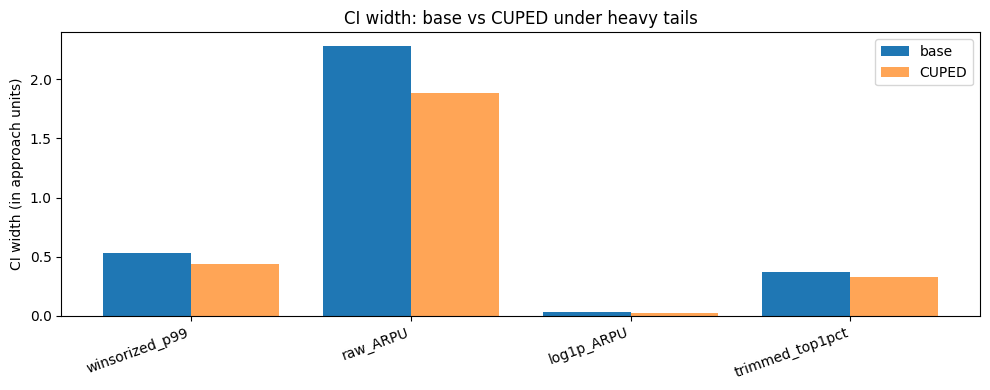

In [8]:
plt.figure(figsize=(10, 4))
x = np.arange(len(ci_tbl))
plt.bar(x - 0.2, ci_tbl["ci_width_base"], width=0.4, label="base")
plt.bar(x + 0.2, ci_tbl["ci_width_cuped"], width=0.4, label="CUPED", alpha=0.7)
plt.xticks(x, ci_tbl["approach"], rotation=20, ha="right")
plt.ylabel("CI width (in approach units)")
plt.title("CI width: base vs CUPED under heavy tails")
plt.legend()
plt.tight_layout()
plt.show()

## 6) Empirical power and type I error (small simulation)
We estimate rejection rates at fixed sample size.

To keep runtime reasonable:

- start with N_ITER = 25
- no bootstrap inside the loop
  
We compare:

- raw ARPU (base vs CUPED)
- winsorized p99 (base vs CUPED)
- log1p ARPU (base vs CUPED)

In [9]:
def pvals_raw_base_cuped(df: pd.DataFrame, alpha: float = ALPHA, seed: int = 0):
    c, t = split_groups(df)

    y_c = c["revenue"].to_numpy(float); y_t = t["revenue"].to_numpy(float)
    x_c = c["revenue_pre"].to_numpy(float); x_t = t["revenue_pre"].to_numpy(float)

    base = welch_ttest_effect(y_c, y_t, alpha=alpha)["p_value"]
    cup_c, cup_t = cuped_ab_crossfit_adjust(y_c, x_c, y_t, x_t, seed=seed)
    cup = welch_ttest_effect(cup_c.y_adj, cup_t.y_adj, alpha=alpha)["p_value"]

    return base, cup


def pvals_winsor_base_cuped(df: pd.DataFrame, alpha: float = ALPHA, seed: int = 0):
    y_all = winsorize(df["revenue"].to_numpy(float), upper_q=0.99)
    x_all = winsorize(df["revenue_pre"].to_numpy(float), upper_q=0.99)
    g = df["group"].to_numpy()

    y_c = y_all[g == "control"]; y_t = y_all[g == "test"]
    x_c = x_all[g == "control"]; x_t = x_all[g == "test"]

    base = welch_ttest_effect(y_c, y_t, alpha=alpha)["p_value"]
    cup_c, cup_t = cuped_ab_crossfit_adjust(y_c, x_c, y_t, x_t, seed=seed)
    cup = welch_ttest_effect(cup_c.y_adj, cup_t.y_adj, alpha=alpha)["p_value"]

    return base, cup


def pvals_log_base_cuped(df: pd.DataFrame, alpha: float = ALPHA, seed: int = 0):
    c, t = split_groups(df)

    y_c = np.log1p(c["revenue"].to_numpy(float)); y_t = np.log1p(t["revenue"].to_numpy(float))
    x_c = np.log1p(c["revenue_pre"].to_numpy(float)); x_t = np.log1p(t["revenue_pre"].to_numpy(float))

    base = welch_ttest_effect(y_c, y_t, alpha=alpha)["p_value"]
    cup_c, cup_t = cuped_ab_crossfit_adjust(y_c, x_c, y_t, x_t, seed=seed)
    cup = welch_ttest_effect(cup_c.y_adj, cup_t.y_adj, alpha=alpha)["p_value"]

    return base, cup


def rejection_rates(cfg: SyntheticB2CConfig, n_iter: int, alpha: float, seed0: int):
    rej = {
        "raw_base": 0, "raw_cuped": 0,
        "win_base": 0, "win_cuped": 0,
        "log_base": 0, "log_cuped": 0,
    }

    for i in range(n_iter):
        cfg_i = SyntheticB2CConfig(**{**cfg.__dict__, "seed": seed0 + i})
        df_i = generate_user_level_data(cfg_i)

        p0, p1 = pvals_raw_base_cuped(df_i, alpha=alpha, seed=seed0 + i)
        rej["raw_base"] += (p0 < alpha); rej["raw_cuped"] += (p1 < alpha)

        p0, p1 = pvals_winsor_base_cuped(df_i, alpha=alpha, seed=seed0 + i)
        rej["win_base"] += (p0 < alpha); rej["win_cuped"] += (p1 < alpha)

        p0, p1 = pvals_log_base_cuped(df_i, alpha=alpha, seed=seed0 + i)
        rej["log_base"] += (p0 < alpha); rej["log_cuped"] += (p1 < alpha)

    for k in rej:
        rej[k] = rej[k] / n_iter

    return rej


N_ITER = 500

cfg_eff = SyntheticB2CConfig(
    n_users=60_000,
    seed=10,
    effect_type="mixed",
    lift_sessions=0.02,
    lift_rev_per_session=0.02,
    include_binary=False,
    revps_lognorm_sigma=1.35,
    high_spender_share=0.05,
    high_revps_multiplier=10.0,
    monetization_latent_sigma=0.8,
)

cfg_null = SyntheticB2CConfig(
    n_users=60_000,
    seed=999,
    effect_type="none",
    lift_sessions=0.0,
    lift_rev_per_session=0.0,
    include_binary=False,
    revps_lognorm_sigma=1.35,
    high_spender_share=0.05,
    high_revps_multiplier=10.0,
    monetization_latent_sigma=0.8,
)

power = rejection_rates(cfg_eff, n_iter=N_ITER, alpha=ALPHA, seed0=5000)
type1 = rejection_rates(cfg_null, n_iter=N_ITER, alpha=ALPHA, seed0=6000)

pd.DataFrame([
    {"case": "power (effect)", **power},
    {"case": "type I error (null)", **type1},
])

,case,raw_base,raw_cuped,win_base,win_cuped,log_base,log_cuped
0,power (effect),0.056,0.078,0.106,0.148,0.162,0.214
1,type I error (null),0.058,0.044,0.054,0.048,0.038,0.044


## Interpretation

Under heavy-tailed revenue, **raw ARPU** typically has low power because the variance is dominated by rare extreme users; even Welch’s t-test can be slightly miscalibrated in this regime.

**Winsorization** (e.g., p99 cap) makes the metric much more stable by limiting outliers. This usually increases power, but it also changes the estimand: you are no longer testing the true mean revenue, but a **capped mean**.

The **log1p** transform changes the estimand even more: the test targets differences in expected `log(1 + revenue)`, which is closer to **relative/multiplicative** changes and is often substantially more robust under heavy tails. In our simulation, `log1p` delivers the highest power among the base (non-CUPED) approaches.

A naive CUPED implementation can **inflate Type I error** under heavy tails because the CUPED coefficient is estimated from the same sample that is later tested (and because additional transformations introduce extra estimated quantities). To address this, we use **cross-fitted (sample-splitting) CUPED**, which restores calibration: Type I error for CUPED variants is close to the target α.

With proper calibration, **CUPED stacks well** with winsorization/log transforms: we combine (a) a better-behaved post-period metric with (b) variance reduction from correlated pre-period information. In the heavy-tail setting tested here, `log1p + cross-fitted CUPED` provides the strongest overall sensitivity while maintaining correct Type I error.

## In production experiments, choose the approach based on:

- **Your official KPI definition**: do you need the true mean (ARPU), or is a robust proxy (winsorized/trimmed/log-scale metric) acceptable?
- **Sensitivity vs interpretability**: robust transforms often improve sensitivity under heavy tails, but they change the estimand and may be harder to communicate.
- **CUPED validity conditions**: the pre-period covariate must be stable, strongly correlated with the post metric, and measured strictly pre-treatment (no leakage).
- **Calibration under heavy tails**: if you apply CUPED to heavy-tailed or transformed metrics (e.g., log or linearized ratios), prefer **cross-fitted (sample-splitting) CUPED** to preserve Type I error control.